# INTRODUCTION OF XGBOOST ALGORITHM:-
Traditional machine learning models like decision trees and random forests are easy to interpret but often struggle with accuracy on complex datasets. XGBoost short form for eXtreme Gradient Boosting is an advanced machine learning algorithm designed for efficiency, speed and high performance.

It is an optimized implementation of Gradient Boosting and is a type of ensemble learning method that combines multiple weak models to form a stronger model.

XGBoost uses decision trees as its base learners and combines them sequentially to improve the model’s performance. Each new tree is trained to correct the errors made by the previous tree and this process is called boosting.
It has built-in parallel processing to train models on large datasets quickly. XGBoost also supports customizations allowing users to adjust model parameters to optimize performance based on the specific problem.

# Let's first understand the Mathematical Concepts and Formula used behind the XGBoost Algorithm:-

# 📘 Mathematical Formulas Used in XGBoost

#1. Objective Function

$$\mathcal{L}(\phi) = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^t \Omega(f_k)$$

#Combines loss function (measuring prediction error) and regularization (controls complexity of trees).


$$\Omega(f_k) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2 = number of leaves,  = weight of leaf,  = regularization parameters.$$



#---

# 2. Additive Model

$$\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)Predictions are updated in each boosting iteration by adding a new tree .$$



#---

# 3. Second Order Approximation

$$\mathcal{L}^{(t)} \approx \sum_{i=1}^n \bigg[ l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \bigg] + \Omega(f_t)$$

#Expands the objective using Taylor approximation up to the second order for efficient optimization.


#Where:

$$g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}, \quad h_i = \frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}= gradient,  = hessian.$$



#---

# 4. Gradient and Hessian for Logistic Loss

$$g_i = \sigma(\hat{y}_i) - y_i, \quad h_i = \sigma(\hat{y}_i)(1 - \sigma(\hat{y}_i))$$

#Where:

$$\sigma(\hat{y}_i) = \frac{1}{1 + e^{-\hat{y}_i}}$$

#For binary classification, gradient and hessian are computed from logistic loss.



#---

# 5. Optimal Leaf Weight

$$w^* = -\frac{\sum_{i \in I} g_i}{\sum_{i \in I} h_i + \lambda}$$

#The best weight for a leaf minimizes the objective.



#---

# 6. Split Gain

$$\text{Gain} = \frac{1}{2} \bigg[ \frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \bigg] - \gamma$$

#Measures improvement in the objective if a node is split into left and right.



#---

# 7. Final Prediction

$$\hat{y}_i = \sum_{t=1}^T f_t(x_i), \quad \hat{p}_i = \sigma(\hat{y}_i) \; \text{(for classification)}$$

#The final score is the sum of all tree outputs; for classification, apply the sigmoid function.

# REFERENCES:-
✅ Official Documentation & Paper

1. XGBoost Official Docs
https://xgboost.readthedocs.io
(The primary source for API and implementation details.)


2. Original XGBoost Research Paper (by Tianqi Chen)
https://arxiv.org/abs/1603.02754
(Explains the mathematical formulation and tree boosting algorithm.)

In [77]:
## Load dataset
import seaborn as sns
df=sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Now,by using above explained concepts and formulas,Let's build our simpleXGBoost Model

In [79]:

class SimpleXGBoost:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, reg_lambda=1.0, gamma=0.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = []
        self.train_losses=[]
        self.loss_history = []
        self.feature_importances_ = None
        self.feature_names = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _log_loss(self, y_true, y_pred):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        self.feature_names = [f"feature_{i}" for i in range(X.shape[1])]
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        self.feature_importances_ = np.zeros(n_features)
        y_pred = np.zeros(n_samples)

        for t in range(self.n_estimators):
            p = self._sigmoid(y_pred)
            g = p - y
            h = p * (1 - p)           #✅ 1. h:-Meaning: Hessian (second derivative of the loss function) for a single sample.
                                      #✅ 2. p:-Meaning: Predicted probability for the current iteration.
                                            
                                         #Purpose of using p: Converts log-odds to probability using the sigmoid function.

            tree = self._build_tree(X, g, h, depth=0)
            self.trees.append(tree)

            # Update predictions
            y_pred += self.learning_rate * self._predict_tree(X, tree)

            # Track loss
            loss = self._log_loss(y, self._sigmoid(y_pred))
            self.loss_history.append(loss)

            # Update feature importances
            self.feature_importances_ += self._calculate_feature_importance(tree)

    def _build_tree(self, X, g, h, depth):
        if depth >= self.max_depth or X.shape[0] <= 1:   #We our checking conditions if we insert depth greater than maximum depth or if shape is none
            w = -np.sum(g) / (np.sum(h) + self.reg_lambda)
            return {"leaf": w}

        best_gain, best_feat, best_thresh = 0, None, None
        G, H = np.sum(g), np.sum(h)                   #✅ 3.G:- Meaning: Gradient sum for a leaf (or a node).            #✅ 4. Meaning: Hessian sum for a leaf (or a node).
                                                      #Purpose: Used in computing the optimal weight for a leaf node
                                                                                                                  #Purpose: Used to compute the leaf weight in the denominator for regularization.

                                                           
        

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left_idx = X[:, feature] <= thresh
                right_idx = ~left_idx

                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue

                G_L, H_L = np.sum(g[left_idx]), np.sum(h[left_idx])
                G_R, H_R = np.sum(g[right_idx]), np.sum(h[right_idx])

                # Gain formula to split the data-points
                gain = 0.5 * ((G_L**2)/(H_L+self.reg_lambda) + (G_R**2)/(H_R+self.reg_lambda) - (G**2)/(H+self.reg_lambda)) - self.gamma
                if gain > best_gain:
                    best_gain, best_feat, best_thresh = gain, feature, thresh

        if best_gain == 0:
            w = -np.sum(g) / (np.sum(h) + self.reg_lambda)
            return {"leaf": w}

        left_idx = X[:, best_feat] <= best_thresh
        right_idx = ~left_idx

        left = self._build_tree(X[left_idx], g[left_idx], h[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], g[right_idx], h[right_idx], depth + 1)

        return {"feature": best_feat, "threshold": best_thresh, "left": left, "right": right}
    #Now,We are building the tree according to the thereshold value
    def _predict_tree(self, X, tree):  
        preds = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            node = tree
            while "leaf" not in node:
                if X[i, node["feature"]] <= node["threshold"]:
                    node = node["left"]
                else:
                    node = node["right"]
            preds[i] = node["leaf"]
        return preds

    def predict_proba(self, X):      # purpose:-Predict Probabilities
        X = X.values if isinstance(X, pd.DataFrame) else X
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * self._predict_tree(X, tree)
        return self._sigmoid(y_pred)

    def predict(self, X):   # purpose:-Predict binary class labels(0 or 1) by applyong threshold(0.5)
        return (self.predict_proba(X) >= 0.5).astype(int)

    def _calculate_feature_importance(self, tree):  #here,we are traversing the nodes so tthat we can find the impotance of each feature 
        importance = np.zeros(len(self.feature_names))
        def traverse(node):
            if "leaf" in node:
                return
            importance[node["feature"]] += 1
            traverse(node["left"])
            traverse(node["right"])
        traverse(tree)
        return importance

    # ==================== Visualization Methods ====================

    def plot_feature_importance(self):
        sorted_idx = np.argsort(self.feature_importances_)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(self.feature_importances_)), self.feature_importances_[sorted_idx])
        plt.yticks(range(len(self.feature_importances_)), [self.feature_names[i] for i in sorted_idx])
        plt.xlabel("Importance")
        plt.title("Feature Importance (Custom XGBoost)")
        plt.show()

    def plot_loss_curve(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(self.loss_history)+1), self.loss_history, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Log Loss")
        plt.title("Training Loss over Iterations")
        plt.grid()
        plt.show()

    def plot_probability_distribution(self, X):
        y_pred_proba = self.predict_proba(X)
        plt.figure(figsize=(8, 5))
        plt.hist(y_pred_proba, bins=20, color='blue', alpha=0.7)
        plt.xlabel("Predicted Probability")
        plt.ylabel("Frequency")
        plt.title("Distribution of Predicted Probabilities")
        plt.show()

    def plot_roc_curve(self, X, y_true):
        y_pred_proba = self.predict_proba(X)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()



In [80]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8156424581005587


# Now,let's add some visualizations for better understanding

In [81]:

        # ==================== Visualization Methods ====================

    def plot_feature_importance(self):
        sorted_idx = np.argsort(self.feature_importances_)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(self.feature_importances_)), self.feature_importances_[sorted_idx])
        plt.yticks(range(len(self.feature_importances_)), [self.feature_names[i] for i in sorted_idx])
        plt.xlabel("Importance")
        plt.title("Feature Importance (Custom XGBoost)")
        plt.show()

    def plot_loss_curve(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(self.loss_history)+1), self.loss_history, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Log Loss")
        plt.title("Training Loss over Iterations")
        plt.grid()
        plt.show()

    def plot_probability_distribution(self, X):
        y_pred_proba = self.predict_proba(X)
        plt.figure(figsize=(8, 5))
        plt.hist(y_pred_proba, bins=20, color='blue', alpha=0.7)
        plt.xlabel("Predicted Probability")
        plt.ylabel("Frequency")
        plt.title("Distribution of Predicted Probabilities")
        plt.show()

    def plot_roc_curve(self, X, y_true):
        y_pred_proba = self.predict_proba(X)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()
     

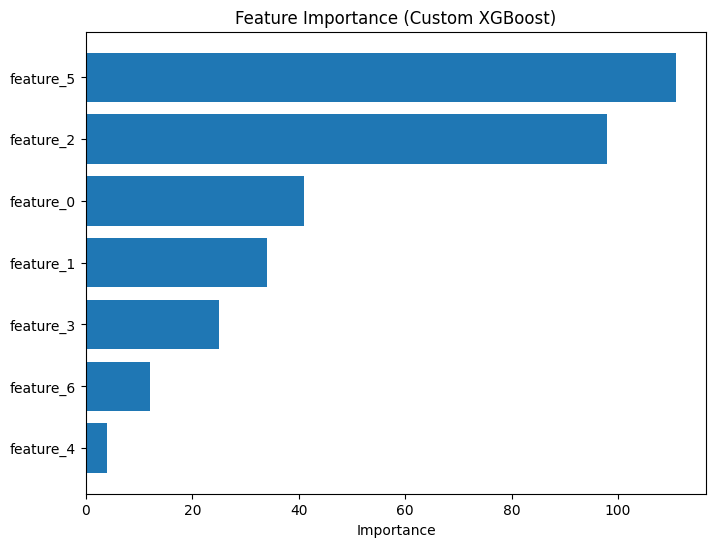

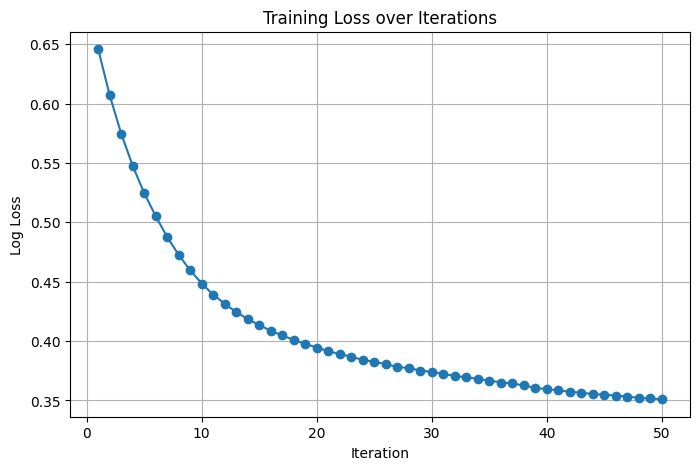

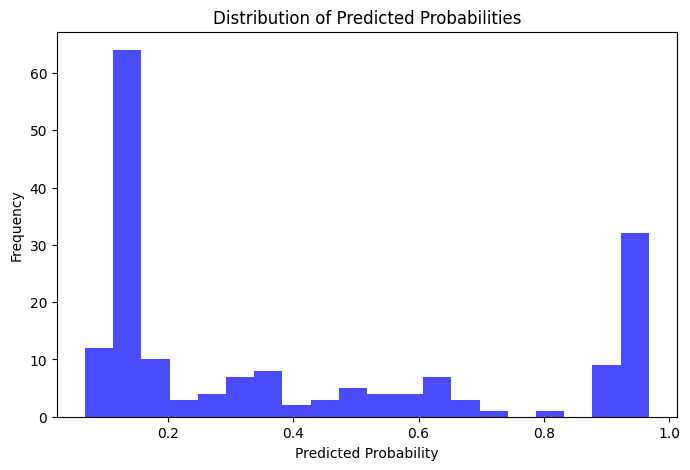

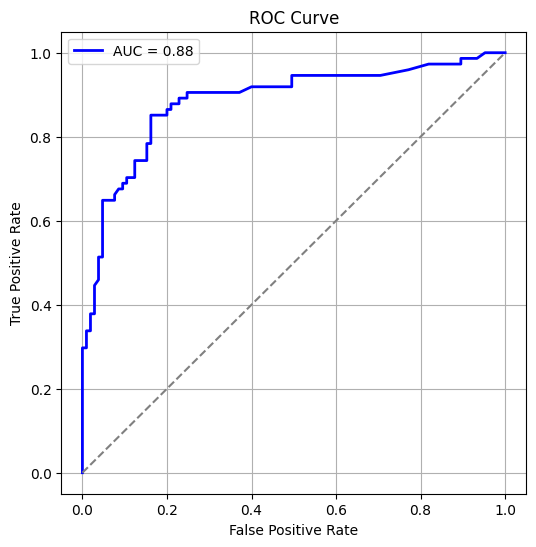

In [82]:
# Train
model = SimpleXGBoost(n_estimators=50, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Visualizations
model.plot_feature_importance()
model.plot_loss_curve()
model.plot_probability_distribution(X_test)
model.plot_roc_curve(X_test, y_test)

In [83]:
#Here,the area under the ROC Curve is 0.88,which is very good.

# CONCLUSION:-
#Hence,we implemented XGBoost Algorithm from scratch to the working process behind each and every line of code.
#The accuracy of our model is 81% due to initializing with better parameters like learning-rate,n_estimatores etc.
#The main thing inside this algorithm is that is uses "multiple decision tree" for predictions and the most important thing is that each tree learns from the error of the previous tree to "boost" the value of prediction and hence this is called "Boosting Algorithm".
#It uses h i.e;"hessian fuction" to find the "second order derivativ"e that makes the updates "more accurate".